## Assignment 3

## Instructions
* This is an individual assignment. You are not allowed to discuss the problems with other students.

* Parts of this assignment will be autograded by gradescope. You can use it as immediate feedback to improve your answers. You can resubmit as many times as you want. Please also note that the **public tests are not exhaustive**, meaning that passing the public tests does not necessarily imply that your implementation is correct. It is recommended to test your implementation in your own ways instead of solely relying on the autograder. 

* All your solution, code, analysis, graphs, and explanations should be done in this same notebook.

* Please make sure to execute all the cells before you submit the notebook to the gradescope. You will not get points for the plots if they are not generated already.

* If you have questions regarding the assignment, you can ask for clarifications in Piazza. You should use the corresponding tag for this assignment.

* Make sure to use Google Colab to avoid unnecessary issues. If you are having issues with Colab, try to restart your runtime ( Runtime -> Restart runtime ) and see if the issues persist.

**Warning:** For this assignment, you are free to use libraries with general utilities, such as *numpy* and *pandas*, and you are expected to use pre-existing implementation of the algorithms available in *scikit-learn*. However, do not use *NLTK* or any other NLP libraries for pre-processing.

## Context
In this assignment, we will build several classifiers with a video game review corpus. This is a classification task with the input as a video game review (text) and the output as the corresponding overall score. Each score belongs to one of 5 classes: 

1. Horrible.
2. Bad.
3. Decent.
4. Good.
5. Great.

The task is then to classify a video game review (text) to the corresponding score. The dataset consists of 25000 video game reviews in the training set and 5000 reviews in each of the validation and test sets. The data is adapted from http://jmcauley.ucsd.edu/data/amazon/.

The next two cells install and initialize otter-grader. You should run these cells as they are WITHOUT modifying them!

In [ ]:
!pip install otter-grader
!git clone https://github.com/chandar-lab/INF8245e-assignments-public.git public

In [2]:
# Initialize Otter
import otter
grader = otter.Notebook(colab=True, tests_dir='./public/assignment_3_python/tests')

Without further ado, let's load our data!

In [3]:
# Import Packages  
import pandas
import numpy
import string

# Load data
train_data = pandas.read_json("./public/assignment_3_python/data/train_data.json", lines=True)[["reviewText", "overall"]]
val_data = pandas.read_json("./public/assignment_3_python/data/val_data.json", lines=True)[["reviewText", "overall"]]
test_data = pandas.read_json("./public/assignment_3_python/data/test_data.json", lines=True)[["reviewText", "overall"]]

Let's take a look at some of our reviews...

In [4]:
val_data

,reviewText,overall
0,"I'm a PC gamer and enjoyed DiRT 1 thoroughly, ...",1
1,hackers all over on team fortress and if you c...,1
2,I had the xbox 360 for a short time when I got...,1
3,Well........ I don't even know how to start of...,1
4,UGGHHH...Why? I really wanted this to be a goo...,1
...,...,...
4995,This bundle is a bargain especially if you hav...,5
4996,"This game, albeit aged, still has better AI th...",5
4997,I got a Gamecube just so I could play this gam...,5
4998,This is adventure bliss.....well done.I am sho...,5


Most of the algorithms described in the class take the input as a vector. However, the reviews are natural language text of a varying number of words. The first step would be to convert this varying-length movie review to a fixed-length vector representation. We will consider two different ways of vectorizing the natural language text: binary bag-of-words representation and frequency bag-of-words representation (as explained next).

### 1. Pre-processing instructions for binary bag-of-words (6 points)

The first step is to construct the word vocabulary for a dataset. Given a dataset, we will only consider the training set and enumerate all unique words in the training set reviews (think about why we should not include validation and test set in the vocabulary construction process). To do this, we should do a bit of pre-processing of the raw text.

**Question 1.1 (2 points):** Pre-process the data by removing punctuation and lower-casing all words. For example, `"Great game!"` would become `"great game"`. Note: spacing between words should remain unchanged.

In [5]:
def remove_punctuation(data: pandas.Series) -> pandas.Series:
    """ Removes punctation marks from data.

    Args:
        data (pandas.Series): a Pandas Series containing the original data

    Returns:
        data_punctuation_free (pandas.Series):a Pandas Series containing the original data withuout punctuation marks
    """
    arg = lambda x: x.translate(str.maketrans('', '', string.punctuation))
    data = data.map(arg)

    return data

def set_to_lower_case(data: pandas.Series) -> pandas.Series:
    """ Sets all characters in data to lower-case.

    Args:
        data (pandas.Series): a Pandas Series containing the original data

    Returns:
        data_lower_cased (pandas.Series): a Pandas Series containing the original data lower-cased
    """
    arg = lambda x: x.lower()
    data = data.map(arg)

    return data

train_data["reviewText"] = remove_punctuation(train_data['reviewText'])
val_data["reviewText"] = remove_punctuation(val_data['reviewText'])
test_data["reviewText"] = remove_punctuation(test_data['reviewText'])

train_data["reviewText"] = set_to_lower_case(train_data['reviewText'])
val_data["reviewText"] = set_to_lower_case(val_data['reviewText'])
test_data["reviewText"] = set_to_lower_case(test_data['reviewText'])

In [6]:
grader.check("q1.1")

q1.1 results: All test cases passed!

**Question 1.2 (2 points):** Now you will construct the vocabulary. First, count the frequency of each word in the training set and sort the words in the vocabulary based on frequency (in descending order). Then, maintaining the aforementioned descending ordering, pick the top 1,000 words in the vocabulary and ignore the rest of the words. These 1,000 words will form the feature set for our classification process.

In [7]:
def pick_most_frequent_words(data: pandas.Series, vocab_size: int) -> list:
    """ Sorts the words in data by frequency in descending order and picks the top vocab_size most frequent words

    Args:
        data (pandas.Series): a Pandas Series containing the original data
        vocab_size (int): the number of top words to pick

    Returns:
        most_frequent_words (list): a list with the top vocab_size most frequent words (in descending order of frequency)
    """
    data = pandas.Series( ' '.join(data).split() ).value_counts().index.to_list()[:vocab_size]

    return data

vocab = pick_most_frequent_words(train_data.reviewText, 1000)

In [8]:
grader.check("q1.2")

q1.2 results: All test cases passed!

**Question 1.3 (2 points):** Generate a 1,000-dimensional feature vector for each example in your dataset such that, for each of the top 1,000 words, there is one corresponding dimension in the feature vector that is 1 if the example contains that word, and 0 otherwise.

In [9]:
def binary_bow(data: numpy.ndarray, vocab: list) -> numpy.ndarray:
    """ Generates a binary vector for each example in data of the size of your vocabulary. Each vector represents which words in the vocabulary are present in each example.

    Args:
        data (numpy.ndarray): the samples to vectorize
        vocab (list): the vocabulary of words

    Returns:
        binary bag-of-words representations (numpy.ndarray): the vectorized samples
    """
    vfunc = numpy.vectorize(lambda a, b: int(a in b.split()))
    data = vfunc(vocab, data[:, None])

    return data

binary_bow_train_data = binary_bow(train_data.reviewText.to_numpy(), vocab)
binary_bow_val_data = binary_bow(val_data.reviewText.to_numpy(), vocab)
binary_bow_test_data = binary_bow(test_data.reviewText.to_numpy(), vocab)

In [10]:
grader.check("q1.3")

q1.3 results: All test cases passed!

### 2. Pre-processing instructions for frequency bag-of-words (3 points)

With the frequency bag-of-words representation, the corresponding feature is now the frequency of occurrence of each of the 1,000 words in a given review.

**Question 2.1 (3 points):** Construct the frequency bag-of-words representations for each example in your dataset. To achieve this, start by summing the occurrences of words in a review into a histogram. Then, divide by the sum of occurrences of all 1,000 words so that the vector for each example sums to 1.

In [11]:
def frequency_bow(data: numpy.ndarray, vocab: list) -> numpy.ndarray:
    """ Generates a real-valued vector for each example in data of the size of your vocabulary. Each vector represents the frequency of occurrence of the words in the vocabulary in each example.

    Args:
        data (numpy.ndarray): the samples to vectorize
        vocab (list): the vocabulary of words

    Returns:
        frequency bag-of-words representations (numpy.ndarray): the vectorized samples
    """
    vfunc = numpy.vectorize(lambda a, b: int(b.split().count(a)))
    data = vfunc(vocab, data[:, None])

    divider = data.sum(axis=1)[:, None]
    divider[divider == 0] = 1 # avoid division by 0

    data = data / divider

    return data

frequency_bow_train_data = frequency_bow(train_data.reviewText.to_numpy(), vocab)
frequency_bow_val_data = frequency_bow(val_data.reviewText.to_numpy(), vocab)
frequency_bow_test_data = frequency_bow(test_data.reviewText.to_numpy(), vocab)

In [12]:
grader.check("q2.1")

q2.1 results: All test cases passed!

### 3. Evaluation metric and baselines (3 points)

We will use the F1 score to evaluate the different classifiers throughout this assignment. Note: you can use sklearn to compute the F1 scores by setting `average = 'micro'`. 

Let's first consider some baseline classifiers!

<!-- BEGIN QUESTION -->

**Question 3.1 (1 point):**  As a first baseline, report the test F1 score of a random classifier (i.e. a model that classifies a review into a uniformly random class). Note: use the provided random number generator variable (**rng**) to generate your random predictions.

In [13]:
from sklearn.metrics import f1_score

y_test = test_data["overall"].to_numpy()

def random_classifier(y_test: numpy.ndarray) -> float:
    """ Returns the F1 score of a random classifier.

    Args:
        y_test (numpy.ndarray): the test labels

    Returns:
        f1_score (float): F1 score between the model predictions and the test labels
    """
    rng = numpy.random.default_rng(0) # use this variable to generate your random predictions

    y_pred = rng.integers(1, 5, size=y_test.size, endpoint=True)
    f1 = f1_score(y_test, y_pred, average='micro')

    return f1

print(f"The test F1 score of the random classifier is {random_classifier(y_test)}")

The test F1 score of the random classifier is 0.1922


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 3.2 (1 point):**  As a second baseline, report the test F1 score of a majority-class classifier (i.e.  a model that computes the majority class in the training set and classifies all test instances as that majority class).

In [14]:
y_train = train_data["overall"].to_numpy()

def majority_classifier(y_train: numpy.ndarray, y_test: numpy.ndarray):
    """ Returns the F1 score of a majority-class classifier.

    Args:
        y_train (numpy.ndarray): the train labels
        y_test (numpy.ndarray): the test labels

    Returns:
        f1_score (float): F1 score between the model predictions and the test labels
    """

    values, counts = numpy.unique(y_train, return_counts=True)
    majority_class = values[ numpy.argmax(counts) ]

    y_pred = numpy.ones_like(y_test)*majority_class
    f1 = f1_score(y_test, y_pred, average='micro')

    return f1

print(f"The test F1 score of the majority-class classifier is {majority_classifier(y_train, y_test)}")

The test F1 score of the majority-class classifier is 0.20000000000000004


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 3.3 (1 point):**  What does the performance of the baseline classifiers suggest about the dataset? (1 sentence)

**Answer 3.3:** The classes are uniformly distributed in the dataset, i.e. there is about the same number of samples belonging to each class.

<!-- END QUESTION -->

### 4. Naive Bayes classifier (4 points)

Now you are ready to start training some classifiers! 

**Question 4.1 (2 points):**  Train a naive Bayes classifier using binary bag-of-words and report the training, validation, and test F1 scores. Use the appropriate naive Bayes classifier for binary input features (Bernoulli naive Bayes) with sklearn's default smoothing parameter. Note: you should call the **fit_and_predict** function throughout the assignment.

In [15]:
def fit_and_predict(model, x_fit: numpy.ndarray, y_fit: numpy.ndarray, x_pred: numpy.ndarray, y_pred: numpy.ndarray) -> float:
    """ Fits a sklearn model using x_fit and y_fit and predicts the labels for x_pred. Returns the F1 score between the model predictions and y_pred

    Args:
        model: sklearn model
        x_fit (numpy.ndarray): the samples to fit
        y_fit (numpy.ndarray): the labels to fit
        x_pred (numpy.ndarray): the samples to predict
        y_pred (numpy.ndarray): the ground truth labels

    Returns:
        f1_score (float): F1 score between the model predictions for x_pred and the ground truth (y_pred)
    """

    model.fit(x_fit, y_fit)

    f1 = f1_score(y_pred, model.predict(x_pred), average='micro')

    return f1

def bernoulli_naive_bayes(binary_bow_train_data: numpy.ndarray, y_train: numpy.ndarray, binary_bow_val_data: numpy.ndarray, y_val: numpy.ndarray, binary_bow_test_data: numpy.ndarray, y_test: numpy.ndarray):
    """ Trains a Benoulli naive Bayes classifier and returns the training, validation, and test F1 scores.

    Args:
        binary_bow_train_data (numpy.ndarray): the binary bag-of-words representations of the training data
        y_train (numpy.ndarray): the labels of the training data
        binary_bow_val_data (numpy.ndarray): the binary bag-of-words representations of the validation data
        y_val (numpy.ndarray): the labels of the validation data
        binary_bow_test_data (numpy.ndarray): the binary bag-of-words representations of the test data
        y_test (numpy.ndarray): the labels of the test data

    Returns:
        train_f1_score (float): F1 score predicted on the training set
        val_f1_score (float): F1 score predicted on the validation set
        test_f1_score (float): F1 score predicted on the test set
    """

    from sklearn.naive_bayes import BernoulliNB

    f1_train_bnb_bow = fit_and_predict(BernoulliNB(), binary_bow_train_data, y_train, binary_bow_train_data, y_train)
    f1_val_bnb_bow = fit_and_predict(BernoulliNB(), binary_bow_train_data, y_train, binary_bow_val_data, y_val)
    f1_test_bnb_bow = fit_and_predict(BernoulliNB(), binary_bow_train_data, y_train, binary_bow_test_data, y_test)

    return f1_train_bnb_bow, f1_val_bnb_bow, f1_test_bnb_bow

y_val = val_data["overall"].to_numpy()

f1_train_bnb_bow, f1_val_bnb_bow, f1_test_bnb_bow = bernoulli_naive_bayes(binary_bow_train_data, y_train, binary_bow_val_data, y_val, binary_bow_test_data, y_test)
print(f"The training, validation, and test F1 scores of the Bernoulli naive Bayes model using binary bag-of-words are {f1_train_bnb_bow}, {f1_val_bnb_bow}, and {f1_test_bnb_bow}")

The training, validation, and test F1 scores of the Bernoulli naive Bayes model using binary bag-of-words are 0.39016, 0.3706, and 0.364


In [16]:
grader.check("q4.1")

q4.1 results: All test cases passed!

**Question 4.2 (2 points):**  Repeat the previous experiment using frequency bag-of-words and report the training, validation, and test F1 scores. Use the appropriate naive Bayes classifier
for real-valued input features (Gaussian naive Bayes) with sklearn's default smoothing parameter.

In [17]:
def gaussian_naive_bayes(frequency_bow_train_data: numpy.ndarray, y_train: numpy.ndarray, frequency_bow_val_data: numpy.ndarray, y_val: numpy.ndarray, frequency_bow_test_data: numpy.ndarray, y_test: numpy.ndarray):
    """ Trains a Gaussian naive Bayes classifier.

    Args:
        frequency_bow_train_data (numpy.ndarray): the frequency bag-of-words representations of the training data
        y_train (numpy.ndarray): the labels of the training data
        frequency_bow_val_data (numpy.ndarray): the frequency bag-of-words representations of the validation data
        y_val (numpy.ndarray): the labels of the validation data
        frequency_bow_test_data (numpy.ndarray): the frequency bag-of-words representations of the test data
        y_test (numpy.ndarray): the labels of the test data

    Returns:
        train_f1_score (float): F1 score predicted on the training set
        val_f1_score (float): F1 score predicted on the validation set
        test_f1_score (float): F1 score predicted on the test set
    """

    from sklearn.naive_bayes import GaussianNB

    f1_train_gnb_fbow = fit_and_predict(GaussianNB(), frequency_bow_train_data, y_train, frequency_bow_train_data, y_train)
    f1_val_gnb_fbow = fit_and_predict(GaussianNB(), frequency_bow_train_data, y_train, frequency_bow_val_data, y_val)
    f1_test_gnb_fbow = fit_and_predict(GaussianNB(), frequency_bow_train_data, y_train, frequency_bow_test_data, y_test)

    return f1_train_gnb_fbow, f1_val_gnb_fbow, f1_test_gnb_fbow

f1_train_gnb_fbow, f1_val_gnb_fbow, f1_test_gnb_fbow = gaussian_naive_bayes(frequency_bow_train_data, y_train, frequency_bow_val_data, y_val, frequency_bow_test_data, y_test)
print(f"The training, validation, and test F1 scores of the Gaussian naive Bayes model using frequency bag-of-words are {f1_train_gnb_fbow}, {f1_val_gnb_fbow}, and {f1_test_gnb_fbow}")

The training, validation, and test F1 scores of the Gaussian naive Bayes model using frequency bag-of-words are 0.40212, 0.37899999999999995, and 0.3472


In [18]:
grader.check("q4.2")

/home/fredericmarcotte/Code/INF8245/env/lib/python3.10/site-packages/sklearn/naive_bayes.py:487: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/home/fredericmarcotte/Code/INF8245/env/lib/python3.10/site-packages/sklearn/naive_bayes.py:488: RuntimeWarning: invalid value encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/home/fredericmarcotte/Code/INF8245/env/lib/python3.10/site-packages/sklearn/naive_bayes.py:487: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/home/fredericmarcotte/Code/INF8245/env/lib/python3.10/site-packages/sklearn/naive_bayes.py:488: RuntimeWarning: invalid value encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/home/fredericmarcotte/Code/INF8245/env/lib/python3.10/site-packages/sklearn/naive_bayes.py:487: RuntimeWarning: divide by zero 

q4.2 results: All test cases passed!

### 5.  Decision trees classifier (6 points)

Now let's try decision trees. From here on, you are expected to do a thorough hyper-parameter tuning by using the given validation set for each classifier. You are expected to use the function below to plot your hyper-parameter tuning in the following two questions.

In [19]:
import matplotlib.pyplot as plt
def visualize_hyperparameter_tuning(hyperparameter_values: list, results: list, best_hyperparameter_value: float):
    """ Plots the F1 scores of the different hyperparameter values and highlights the best hyperparameter value.

    Args:
        hyperparameter_values (list): the hyperparameter values used
        results (list): the F1 scores of each hyperparameter value
        best_hyperparameter_value (float): the best hyperparameter value
    """
    if len(results) == 0: #this is just a placeholder in case there are no results
        results = [0]*len(hyperparameter_values)
    plt.plot(hyperparameter_values, results, "o-")
    plt.axvline(best_hyperparameter_value, color="red", ls="--", label="Best configuration")
    plt.ylabel("F1 score")
    plt.xlabel("Hyper-parameter value")
    plt.legend()
    plt.show()

<!-- BEGIN QUESTION -->

**Question 5.1 (2 points):**  Train a Decision Trees classifier using binary bag-of-words and perform hyper-parameter tuning on the maximum depth of the tree. Plot your hyper-parameter tuning and report the training, validation, and test F1 scores with the best hyper-parameter configuration.

The training, validation, and test F1 scores of the best decision trees model (max_depth: 19) using binary bag-of-words are 0.6298, 0.3322, and 0.3178


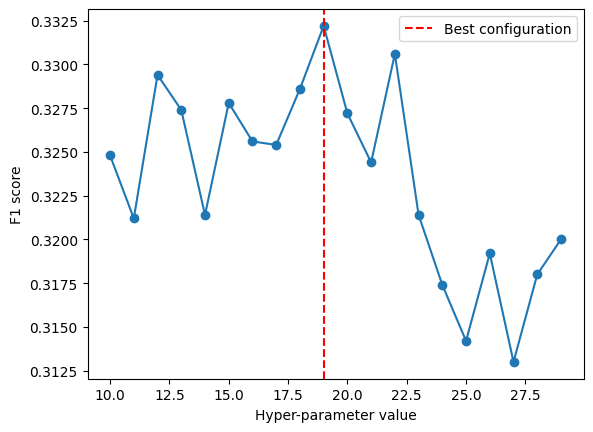

In [102]:
def decision_trees(bow_train_data: numpy.ndarray, y_train: numpy.ndarray, bow_val_data: numpy.ndarray, y_val: numpy.ndarray, bow_test_data: numpy.ndarray, y_test: numpy.ndarray, max_depth_values: list):
    """ Trains a decision trees classifier.

    Args:
        bow_train_data (numpy.ndarray): the bag-of-words representations of the training data
        y_train (numpy.ndarray): the labels of the training data
        bow_val_data (numpy.ndarray): the bag-of-words representations of the validation data
        y_val (numpy.ndarray): the labels of the validation data
        bow_test_data (numpy.ndarray): the bag-of-words representations of the test data
        y_test (numpy.ndarray): the labels of the test data
        max_depth_values (list): the maximum depth values to try

    Returns:
        train_f1_score (float): F1 score predicted on the training set
        val_f1_score (float): F1 score predicted on the validation set
        test_f1_score (float): F1 score predicted on the test set
        f1_scores (list): F1 scores of the different maximum depth values
        best_max_depth (int): maximum depth value with the highest validation F1 score
    """

    f1_scores = []

    from sklearn.tree import DecisionTreeClassifier

    best_f1 = 0
    for max_depth_value in max_depth_values:
        
        # hyper-parameter tuning using the validation set
        f1_val_dt_bow = fit_and_predict(DecisionTreeClassifier(max_depth=max_depth_value, random_state=0),
                                        bow_train_data, y_train, bow_val_data, y_val)
        f1_scores.append(f1_val_dt_bow)

        if f1_val_dt_bow > best_f1:
            best_f1 = f1_val_dt_bow
            best_max_depth = max_depth_value

    f1_train_dt_best_config_bow = fit_and_predict(DecisionTreeClassifier(max_depth=best_max_depth, random_state=0),
                                        bow_train_data, y_train, bow_train_data, y_train)
    f1_val_dt_best_config_bow = fit_and_predict(DecisionTreeClassifier(max_depth=best_max_depth, random_state=0),
                                        bow_train_data, y_train, bow_val_data, y_val)
    f1_test_dt_best_config_bow = fit_and_predict(DecisionTreeClassifier(max_depth=best_max_depth, random_state=0),
                                        bow_train_data, y_train, bow_test_data, y_test)

    return f1_train_dt_best_config_bow, f1_val_dt_best_config_bow, f1_test_dt_best_config_bow, f1_scores, best_max_depth

max_depth_values = list(range(10, 30))

f1_train_dt_best_config_bow, f1_val_dt_best_config_bow, f1_test_dt_best_config_bow, f1_scores, best_max_depth = decision_trees(binary_bow_train_data, y_train, binary_bow_val_data, y_val, binary_bow_test_data, y_test, max_depth_values)
print(f"The training, validation, and test F1 scores of the best decision trees model (max_depth: {best_max_depth}) using binary bag-of-words are {f1_train_dt_best_config_bow}, {f1_val_dt_best_config_bow}, and {f1_test_dt_best_config_bow}")
visualize_hyperparameter_tuning(max_depth_values, f1_scores, best_max_depth)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 5.2 (2 points):**  Repeat the previous experiment by performing hyper-parameter tuning using frequency bag-of-words.

The training, validation, and test F1 scores of the best decision trees model (max_depth: 18) using frequency bag-of-words are 0.60376, 0.3312, and 0.3168


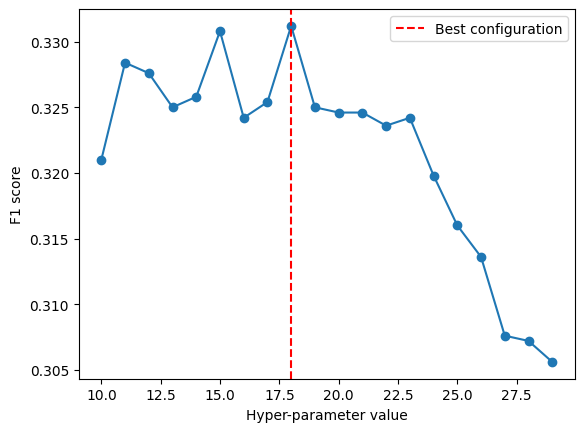

In [104]:
max_depth_values = list(range(10, 30))

f1_train_dt_best_config_fbow, f1_val_dt_best_config_fbow, f1_test_dt_best_config_fbow, f1_scores, best_max_depth = decision_trees(frequency_bow_train_data, y_train, frequency_bow_val_data, y_val, frequency_bow_test_data, y_test, max_depth_values)
print(f"The training, validation, and test F1 scores of the best decision trees model (max_depth: {best_max_depth}) using frequency bag-of-words are {f1_train_dt_best_config_fbow}, {f1_val_dt_best_config_fbow}, and {f1_test_dt_best_config_fbow}")
visualize_hyperparameter_tuning(max_depth_values, f1_scores, best_max_depth)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 5.3 (2 points):**  Explain how you chose the hyperparameter range for each representation. (1-2 sentences)

**Answer 5.3:** I did a first rough search in the max depth range (0, 100, 5). I localized the best F1 score for both representations, and I performed a second fine search around the first maximum, i.e. in the range (10, 30, 1) to obtain a better estimator.

<!-- END QUESTION -->

### 6.  Logistic regression classifier (6 points)

Let's move on to logistic regression. For the rest of the assignment, you will be asked to tune multiple hyper-parameters. Use the function below to plot your finetuning. Note: you will need to fill out the results dictionary appropriately (i.e. {"max_iter: x, C: y": result}).

In [20]:
def visualize_multi_hyperparameter_tuning(results: dict, best_hyperparameter_config: str):
    """ Plots the F1 scores of the different hyperparameter configurations and highlights the best hyperparameter configuration.

    Args:
        results (dict): dictionary with each hyperparameter configuration as key and corresponding F1 score as value
        best_hyperparameter_config (str): the key representing the best hyperparameter configuration in the results dictionary
    """
    if not results: #this is just a placeholder in case there are no results
        for max_iter in [-1, 0, 1]:
            for C in [-1, 0, 1]:
                results[f"max_iter: {max_iter}, C: {C}"] = -1
    plt.plot(range(len(results)), list(results.values()), "o-")
    plt.axvline(list(results.keys()).index(best_hyperparameter_config), color="red", ls="--", label="Best configuration")
    plt.xticks(range(len(results)), list(results.keys()), rotation=90)
    plt.ylabel("F1 score")
    plt.xlabel("Hyper-parameters")
    plt.legend()
    plt.show()

<!-- BEGIN QUESTION -->

**Question 6.1 (2 points):**  Train a Logistic Regression classifier using binary bag-of-words and perform hyper-parameter tuning on the maximum number of iterations as well as the regularization term (C). Plot your hyper-parameter tuning and report the training, validation, and test F1 scores with the best hyper-parameter configuration. Note: it is okay to get convergence warnings.

/home/fredericmarcotte/Code/INF8245/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/fredericmarcotte/Code/INF8245/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

The training, validation, and test F1 scores of the best logistic regression model (max_iter: 100, C: 0.01) using binary bag-of-words are 0.52492, 0.4754, 0.4568


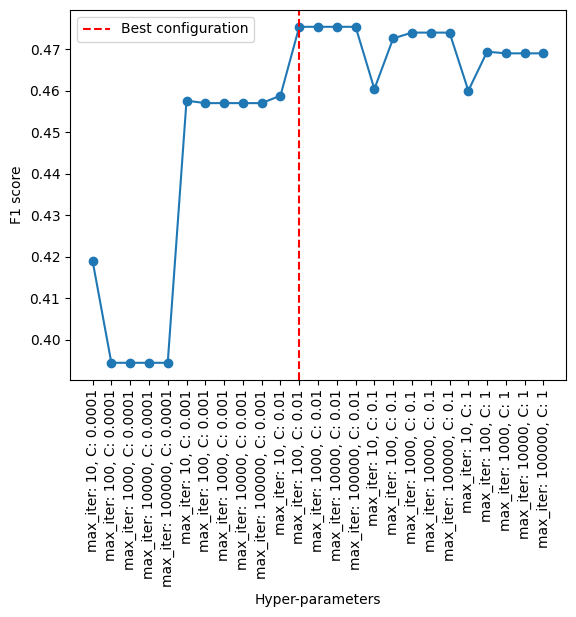

In [106]:
def logistic_regression(bow_train_data: numpy.ndarray, y_train: numpy.ndarray, bow_val_data: numpy.ndarray, y_val: numpy.ndarray, bow_test_data: numpy.ndarray, y_test: numpy.ndarray, C_values: list, max_iter_values: list):
    """ Trains a logistic regression classifier.

    Args:
        bow_train_data (numpy.ndarray): the bag-of-words representations of the training data
        y_train (numpy.ndarray): the labels of the training data
        bow_val_data (numpy.ndarray): the bag-of-words representations of the validation data
        y_val (numpy.ndarray): the labels of the validation data
        bow_test_data (numpy.ndarray): the bag-of-words representations of the test data
        y_test (numpy.ndarray): the labels of the test data
        C_values (list): the C values to try
        max_iter_values (list): the maximum iteration values to try

    Returns:
        train_f1_score (float): F1 score predicted on the training set
        val_f1_score (float): F1 score predicted on the validation set
        test_f1_score (float): F1 score predicted on the test set
        f1_scores (list): F1 scores of the different maximum depth values
        best_C (float): C value with the highest validation F1 score
        best_max_iter (float): maximum iteration value with the highest validation F1 score
    """

    f1_scores = {}

    from sklearn.linear_model import LogisticRegression

    best_f1 = 0
    for C_value in C_values:
        for max_iter_value in max_iter_values:
            
            # hyper-parameter tuning using the validation set
            f1_val_lr_bow = fit_and_predict(LogisticRegression(C=C_value, max_iter=max_iter_value, random_state=0),
                                            bow_train_data, y_train, bow_val_data, y_val)
            f1_scores[f"max_iter: {max_iter_value}, C: {C_value}"] = f1_val_lr_bow

            if f1_val_lr_bow > best_f1:
                best_f1 = f1_val_lr_bow
                best_C = C_value
                best_max_iter = max_iter_value

    f1_train_lr_best_config_bow = fit_and_predict(LogisticRegression(C=best_C, max_iter=best_max_iter, random_state=0),
                                                  bow_train_data, y_train, bow_train_data, y_train)
    f1_val_lr_best_config_bow = fit_and_predict(LogisticRegression(C=best_C, max_iter=best_max_iter, random_state=0),
                                                  bow_train_data, y_train, bow_val_data, y_val)
    f1_test_lr_best_config_bow = fit_and_predict(LogisticRegression(C=best_C, max_iter=best_max_iter, random_state=0),
                                                  bow_train_data, y_train, bow_test_data, y_test)

    return f1_train_lr_best_config_bow, f1_val_lr_best_config_bow, f1_test_lr_best_config_bow, f1_scores, best_C, best_max_iter

C_values = [0.0001, 0.001, 0.01, 0.1, 1]
max_iter_values = [10, 100, 1000, 10000, 100000]

f1_train_lr_best_config_bow, f1_val_lr_best_config_bow, f1_test_lr_best_config_bow, f1_scores, best_C, best_max_iter = logistic_regression(binary_bow_train_data, y_train, binary_bow_val_data, y_val, binary_bow_test_data, y_test, C_values, max_iter_values)
print(f"The training, validation, and test F1 scores of the best logistic regression model (max_iter: {best_max_iter}, C: {best_C}) using binary bag-of-words are {f1_train_lr_best_config_bow}, {f1_val_lr_best_config_bow}, {f1_test_lr_best_config_bow}")
visualize_multi_hyperparameter_tuning(f1_scores, f"max_iter: {best_max_iter}, C: {best_C}")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 6.2 (2 points):**  Repeat the previous experiment by performing hyper-parameter tuning using frequency bag-of-words. Note: it is okay to get convergence warnings.

/home/fredericmarcotte/Code/INF8245/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/fredericmarcotte/Code/INF8245/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

The training, validation, and test F1 scores of the best logistic regression model (max_iter: 10000, C: 100) using frequency bag-of-words are 0.53476, 0.4836, 0.4534


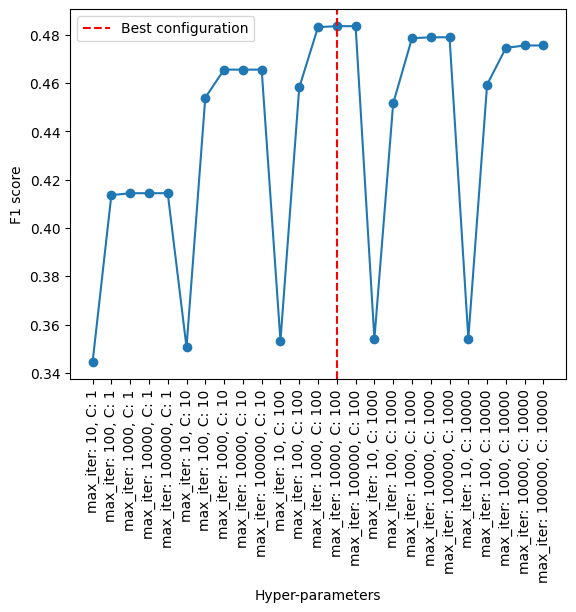

In [107]:

C_values = [1, 10, 100, 1000, 10000]
max_iter_values = [10, 100, 1000, 10000, 100000]

f1_train_lr_best_config_fbow, f1_val_lr_best_config_fbow, f1_test_lr_best_config_fbow, f1_scores, best_C, best_max_iter = logistic_regression(frequency_bow_train_data, y_train, frequency_bow_val_data, y_val, frequency_bow_test_data, y_test, C_values, max_iter_values)
print(f"The training, validation, and test F1 scores of the best logistic regression model (max_iter: {best_max_iter}, C: {best_C}) using frequency bag-of-words are {f1_train_lr_best_config_fbow}, {f1_val_lr_best_config_fbow}, {f1_test_lr_best_config_fbow}")
visualize_multi_hyperparameter_tuning(f1_scores, f"max_iter: {best_max_iter}, C: {best_C}")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 6.3 (2 points):**  Explain how you chose the hyperparameter range for each representation. (1-2 sentences)

**Answer 6.3:** I did a first search on a logarithmic grid for C $\in (0.001: 10)$ and max_iter $\in (10: 100000)$. For each representation, I located the first maximum and centered a second grid search on it. For the binary bow representation, it meant C $\in (0.0001: 1)$; and for the frequency bow representation, it meant C $\in (1: 10000)$. It can be seen that the F1 score saturates after a certain maximum number of iterations, thus I did not go beyond max_iter=100000.

<!-- END QUESTION -->

### 7.  Linear SVM classifier (6 points)

Lastly, let's try a linear SVM classifier.

<!-- BEGIN QUESTION -->

**Question 7.1 (2 points):**  Train a Linear SVM classifier using binary bag-of-words and perform hyper-parameter tuning on the maximum number of iterations as well as the regularization term (C). Plot your hyper-parameter tuning and report the training, validation, and test F1 scores with the best hyper-parameter configuration. Note: it is okay to get convergence warnings.

/home/fredericmarcotte/Code/INF8245/env/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/fredericmarcotte/Code/INF8245/env/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/fredericmarcotte/Code/INF8245/env/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/fredericmarcotte/Code/INF8245/env/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/fredericmarcotte/Code/INF8245/env/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


The training, validation, and test F1 scores of the best linear SVM model (max_iter: 100, C: 0.001) using binary bag-of-words are 0.51928, 0.4732, 0.4492


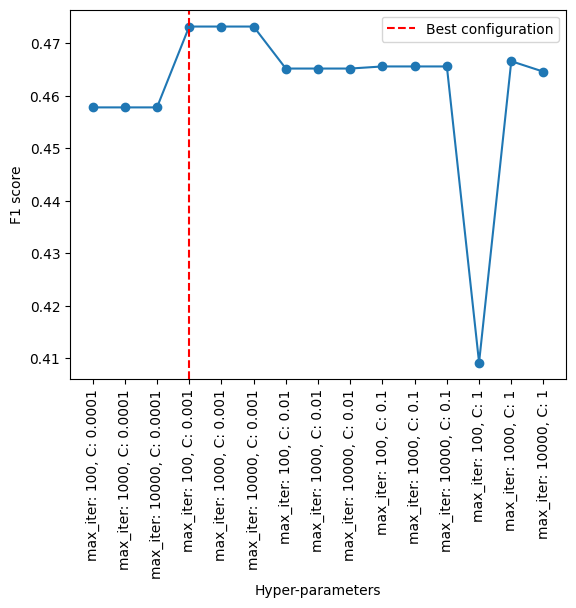

In [26]:
def linear_svm(bow_train_data: numpy.ndarray, y_train: numpy.ndarray, bow_val_data: numpy.ndarray, y_val: numpy.ndarray, bow_test_data: numpy.ndarray, y_test: numpy.ndarray, C_values: list, max_iter_values: list):
    """ Trains a linear SVM classifier.

    Args:
        bow_train_data (numpy.ndarray): the bag-of-words representations of the training data
        y_train (numpy.ndarray): the labels of the training data
        bow_val_data (numpy.ndarray): the bag-of-words representations of the validation data
        y_val (numpy.ndarray): the labels of the validation data
        bow_test_data (numpy.ndarray): the bag-of-words representations of the test data
        y_test (numpy.ndarray): the labels of the test data
        C_values (list): the C values to try
        max_iter_values (list): the maximum iteration values to try

    Returns:
        train_f1_score (float): F1 score predicted on the training set
        val_f1_score (float): F1 score predicted on the validation set
        test_f1_score (float): F1 score predicted on the test set
        f1_scores (list): F1 scores of the different maximum depth values
        best_C (float): C value with the highest validation F1 score
        best_max_iter (float): maximum iteration value with the highest validation F1 score
    """

    f1_scores = {}

    from sklearn.svm import LinearSVC

    best_f1 = 0
    for C_value in C_values:
        for max_iter_value in max_iter_values:
            
            # hyper-parameter tuning using the validation set
            f1_val_svm_bow = fit_and_predict(LinearSVC(C=C_value, max_iter=max_iter_value, random_state=0),
                                            bow_train_data, y_train, bow_val_data, y_val)
            f1_scores[f"max_iter: {max_iter_value}, C: {C_value}"] = f1_val_svm_bow

            if f1_val_svm_bow > best_f1:
                best_f1 = f1_val_svm_bow
                best_C = C_value
                best_max_iter = max_iter_value

    f1_train_svm_best_config_bow = fit_and_predict(LinearSVC(C=best_C, max_iter=best_max_iter, random_state=0),
                                                  bow_train_data, y_train, bow_train_data, y_train)
    f1_val_svm_best_config_bow = fit_and_predict(LinearSVC(C=best_C, max_iter=best_max_iter, random_state=0),
                                                  bow_train_data, y_train, bow_val_data, y_val)
    f1_test_svm_best_config_bow = fit_and_predict(LinearSVC(C=best_C, max_iter=best_max_iter, random_state=0),
                                                  bow_train_data, y_train, bow_test_data, y_test)

    return f1_train_svm_best_config_bow, f1_val_svm_best_config_bow, f1_test_svm_best_config_bow, f1_scores, best_C, best_max_iter

C_values = [0.0001, 0.001, 0.01, 0.1, 1]
max_iter_values = [100, 1000, 10000]

f1_train_svm_best_config_bow, f1_val_svm_best_config_bow, f1_test_svm_best_config_bow, f1_scores, best_C, best_max_iter = linear_svm(binary_bow_train_data, y_train, binary_bow_val_data, y_val, binary_bow_test_data, y_test, C_values, max_iter_values)

print(f"The training, validation, and test F1 scores of the best linear SVM model (max_iter: {best_max_iter}, C: {best_C}) using binary bag-of-words are {f1_train_svm_best_config_bow}, {f1_val_svm_best_config_bow}, {f1_test_svm_best_config_bow}")
visualize_multi_hyperparameter_tuning(f1_scores, f"max_iter: {best_max_iter}, C: {best_C}")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 7.2 (2 points):**  Repeat the previous experiment by performing hyper-parameter tuning using frequency bag-of-words. Note: it is okay to get convergence warnings.

/home/fredericmarcotte/Code/INF8245/env/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/fredericmarcotte/Code/INF8245/env/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/fredericmarcotte/Code/INF8245/env/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/fredericmarcotte/Code/INF8245/env/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/fredericmarcotte/Code/INF8245/env/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/fred

The training, validation, and test F1 scores of the best linear SVM model (max_iter: 1000, C: 100) using frequency bag-of-words are 0.5354, 0.48, 0.4478


/home/fredericmarcotte/Code/INF8245/env/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


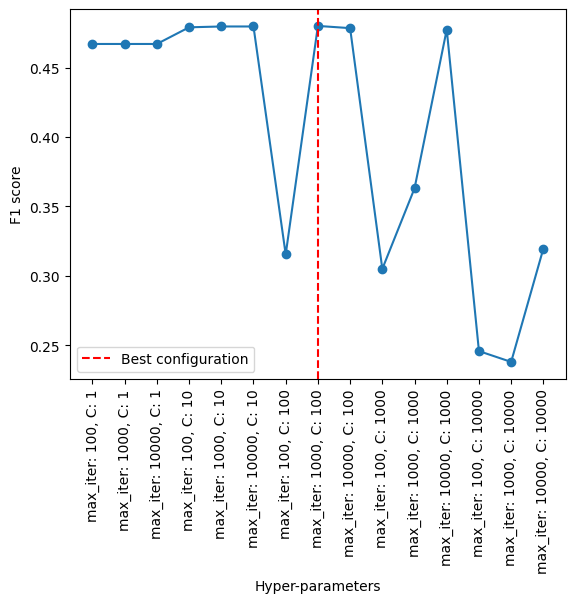

In [29]:
C_values = [1, 10, 100, 1000, 10000]
max_iter_values = [100, 1000, 10000]

f1_train_svm_best_config_fbow, f1_val_svm_best_config_fbow, f1_test_svm_best_config_fbow, f1_scores, best_C, best_max_iter = linear_svm(frequency_bow_train_data, y_train, frequency_bow_val_data, y_val, frequency_bow_test_data, y_test, C_values, max_iter_values)
print(f"The training, validation, and test F1 scores of the best linear SVM model (max_iter: {best_max_iter}, C: {best_C}) using frequency bag-of-words are {f1_train_svm_best_config_fbow}, {f1_val_svm_best_config_fbow}, {f1_test_svm_best_config_fbow}")
visualize_multi_hyperparameter_tuning(f1_scores, f"max_iter: {best_max_iter}, C: {best_C}")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 7.3 (2 points):**  Explain how you chose the hyperparameter range for each representation. (1-2 sentences)

**Answer 7.3:** I did a first search on a logarithmic grid for C $\in (0.001: 10)$ and max_iter $\in (100: 10000)$. For each representation, I located the first maximum and centered a second grid search on it. For the binary bow representation, it meant C $\in (0.0001: 1)$; and for the frequency bow representation, it meant C $\in (1: 10000)$. It can be seen that the F1 score saturates after a certain maximum number of iterations, thus I did not go beyond max_iter=10000.

<!-- END QUESTION -->

### 8.  Analysis and discussion (16 points)

It is time to analyze and discuss your results.

<!-- BEGIN QUESTION -->

**Question 8.1 (1 point):**  Report the performance of the different classifiers when using binary bag-of-words.

**Answer 8.1:** 

|        Classifier      | F1 score (train) | F1 score (val) | F1 score (test) |
|------------------------|:----------------:|:--------------:|:---------------:|
|  Bernoulli Naive Bayes |       0.39016        |      0.37060       |       0.36400       |
|     Decision trees     |       0.62980        |      0.33220       |       0.31780       |
|   Logistic regression  |       0.52492        |      0.47540       |       0.45680       |
|        Linear SVM      |       0.51928        |      0.47320       |       0.44920       |

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 8.2 (1 point):**  Report the performance of the different classifiers when using frequency bag-of-words.

**Answer 8.2:** 

|        Classifier      | F1 score (train) | F1 score (val) | F1 score (test) |
|------------------------|:----------------:|:--------------:|:---------------:|
|  Gaussian Naive Bayes  |       0.40212        |      0.37900       |       0.34720       |
|     Decision trees     |       0.60376        |      0.33120       |       0.31680       |
|   Logistic regression  |       0.53476        |      0.48360       |       0.45340       |
|        Linear SVM      |       0.53540        |      0.48000       |       0.44780       |

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 8.3 (7 points):**  Analyze the performance of the different classifiers. Is there a particular classifier or subset of classifiers that perform better than the rest? Discuss the impact of the hyper-parameter range that you considered for each classifier.  (3-5 sentences)

**Answer 8.3:** Decision trees have the lowest test F1 score, followed by generative models (Bernoulli and Gaussian naive Bayes). Discriminative (logistic regression) and discriminant-based (linear SVM) models perform the best, with a small advantage for logistic regression. The performance ranking of the different classifiers holds for both (binary and frequency) representations. For each classifier, the hyper-parameter range was adapted to reach the highest validation F1 score, thus minimizing the impact of this range when comparing different models. For decision trees, we tuned the maximal depth with unitary steps, resulting in the best possible depth. For logistic regression and linear SVM, we performed a less precise tuning by considering only powers of 10 values for C and the maximal number of iterations, but we were consistent with this approach when training both models.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 8.4 (7 points):**  Analyze the performance of the different representations and discuss their limitations. Can you think of ways of improving the frequency bag-of-words representation? (3-5 sentences)

**Answer 8.4:** Both representations offer very similar performance, although the binary bag-of-word is slightly better. An important limitation of bag-of-word is that it ignores the location of words in the text (can be leveraged by considering CNN or RNN). Also, it doesn't account for words with the same meaning, i.e. synonyms. Bag-of-word can give too much importance to words widely used (the, a, of, etc.) and not enough importance to specific words not used often. To improve the frequency bag-of-words representation, one could consider standard or minmax scaling as a preprocessing step. In this assignment, the frequency vector values can be very small (much smaller than 1). This can result in learning large weight values, thus yielding an unstable model. This possible issue can be solved by scaling the values in the range [0, 1] (rather than simple normalization so that the vectors sum to 1).

<!-- END QUESTION -->

